In [8]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
import math
import copy
import matplotlib.pyplot as plt
%matplotlib inline
from tensorboardX import SummaryWriter

from scipy import fft
import librosa

import torch.optim as optim
import pandas as pd
import numpy as np
import sys
import os
sys.path.append('/home/administrator/workspace/ESC-50')
from utils import ESC50

In [4]:
class Normalisation(nn.Module):
    def __init__(self,hi,eps=1e-6):
        super(Normalisation, self).__init__()
        self.L = nn.Parameter(torch.Tensor(1))
        self.B = nn.Parameter(torch.Tensor(1))
        self.hi = hi
        self.eps = eps
        self.reset_parameters()
        self.Sigmoid = nn.Sigmoid()
        
    def reset_parameters(self):
        nn.init.uniform_(self.L,-1,1)
        nn.init.uniform_(self.B,-1,1)
    
    def mul_sigmoid(self, weight):
        return self.Sigmoid(weight)+0.5
    
    def add_sigmoid(self, weight):
        return self.Sigmoid(weight)-0.5 
    
    def forward(self, weight):
        
        if self.hi:
            mean = weight.mean(-1)
            weight = weight-mean
            div = torch.sqrt(weight.pow(2).sum(-1)+self.eps)
            normilized_weight = weight/div
            normilized_weight = self.mul_sigmoid(self.L)*normilized_weight+self.add_sigmoid(self.B)
        else:            
            div = torch.sqrt(weight.pow(2).sum(-1)+self.eps)
            normilized_weight = weight/div
            normilized_weight = self.mul_sigmoid(self.L)*normilized_weight 

        return normilized_weight
        

In [5]:
class Wavelet(nn.Module):
    def __init__(self, num_layers, kernel_size, stride=1,
                 padding=1, dilation=1, groups=1, disp=False, norm=False):
        super(Wavelet, self).__init__()
        
        self.num_layers = num_layers
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        self.groups = groups
        self.disp = disp
        self.norm = norm
        
        if self.norm:
            self.hi_Norm = Normalisation(True)
            self.lo_Norm = Normalisation(False)
        self.weight_hi = nn.Parameter(torch.Tensor(1,1,kernel_size).cuda())
        self.weight_lo = nn.Parameter(torch.Tensor(1,1,kernel_size).cuda())
        
        self.weights = []
        self.weights.append(self.weight_hi) 
        for i in range(1,num_layers):
            self.weights.append(torch.Tensor(1,1,kernel_size*(2**i)))
        self.weights.append(torch.Tensor(1,1,kernel_size*2**(num_layers-1)))
        
        self.weights_dec = copy.deepcopy(self.weights)
        
        self.reset_parameters()

# # Из фильтра высоких частот        
    def reset_parameters(self):
        nn.init.xavier_uniform_(self.weight_hi)
#         nn.init.uniform_(self.weight_lo)
#         self.weight_lo = nn.Parameter(torch.tensor([[[1,1]]], dtype=torch.float32))
#         self.weight_hi = nn.Parameter(torch.tensor([[[0,-0.48296291314469025,0.836516303737469, \
#                         -0.22414386804185735,-0.12940952255092145,0]]], dtype=torch.float32))
        weight_hi = self.weight_hi-self.weight_hi.mean()
        self.weight_hi = nn.Parameter(weight_hi/torch.sqrt(self.energy(weight_hi)))
        idx = torch.arange(self.weight_lo.size(2)-1, -1, -1).long()
        weight_lo = self.weight_hi[:,:,idx]
        odd = torch.arange(1, self.weight_lo.size(2), 2).long()
        weight_lo[:,:,odd] = weight_lo[:,:,odd]*-1
        self.weight_lo = nn.Parameter(weight_lo)

        
    def energy(self, tensor):
        return (tensor.pow(2).sum())
    
    def upsample(self, weigth, filt, filt_rec):
        kernel_size = weigth.shape[-1]
        filt_size = filt.shape[-1]
        upsampeled = torch.zeros((1,1,kernel_size*2-1)).cuda() #cuda does't implements automaticly 
    
        upsampeled[:,:,::2] = weigth
        upsampeled_pad = F.pad(upsampeled,(math.ceil(filt_size/2),math.floor(filt_size/2))) #padding
#         upsampeled_pad = F.pad(upsampeled,(filt_size-1,filt_size-1)) #padding
        idx = torch.arange(upsampeled_pad.size(2)-1, -1, -1).long()
        return upsampeled, F.conv1d(upsampeled_pad, filt), F.conv1d(upsampeled_pad[:,:,idx], filt_rec)
        
    def reset_weights_enc(self, weight_lo, weight_hi):
        self.weights[0] = weight_hi
        idx = torch.arange(weight_hi.size(2)-1, -1, -1).long()
        self.weights_dec[0] = weight_hi[:,:,idx]
        last_lo = weight_lo
        last_hi = weight_hi
#         print (self.energy(self.weight_lo), self.energy(self.weight_hi), self.energy(last_lo) , self.energy(last_hi) )
        accumulated_lo = weight_lo
        accumulated_lo_dec = weight_lo[:,:,idx]
        
        for i in range(1,self.num_layers):
            last_hi, self.weights[i], self.weights_dec[i] = self.upsample(last_hi, accumulated_lo,
                                                                        accumulated_lo_dec)
            last_lo, accumulated_lo, accumulated_lo_dec = self.upsample(last_lo, accumulated_lo,
                                                                        accumulated_lo_dec)
        self.weights[self.num_layers] = accumulated_lo
        self.weights_dec[self.num_layers] = accumulated_lo_dec
        if self.disp:
            for w in self.weights[:]:
                print (self.energy(w.data))
#                 plt.plot(np.linspace(0,1,w.size(2)),w.data.numpy()[0,0,:])
        
    def reset_weights_dec(self):
        for i,weight in enumerate(self.weights):            
            inv_idx = torch.arange(weight.size(2)-1, -1, -1).long()
            self.weights_dec[i] = weight[:,:,inv_idx]
#         for w in self.weights_dec:
#             print (w)


    def encoding(self,data):
        if self.norm:
            weight_hi = self.hi_Norm(self.weight_hi)
            weight_lo = self.lo_Norm(self.weight_lo)
            self.reset_weights_enc(weight_hi,weight_lo)
        else:
            self.reset_weights_enc(self.weight_hi,self.weight_lo)
        encoding = torch.Tensor(data.size(0),self.num_layers+1,data.size(2)).cuda()
        for i,weight in enumerate(self.weights):
            filt_size = weight.size(2)-1
            left = math.ceil(filt_size/2)
            rigth = math.floor(filt_size/2)
#             print (i,F.conv1d(F.pad(data,(left,rigth)), weight))
            encoding[:,i,:] = F.conv1d(F.pad(data,(left,rigth)), weight).squeeze(1)
        return encoding
    
    def decoding(self,encoding):
#         self.reset_weights_dec()
        decoding = torch.zeros((encoding.size(0),1,encoding.size(2))).cuda()
        for i,weight in enumerate(self.weights_dec):
            filt_size = weight.size(2)-1
            left = math.floor(filt_size/2)
            rigth = math.ceil(filt_size/2)
#             tmp = F.conv1d(F.pad(encoding[:,i,:].unsqueeze(1),(left,rigth)), weight)
#             print (i, tmp)
            decoding += F.conv1d(F.pad(encoding[:,i,:].unsqueeze(1),(left,rigth)), weight)
#             print (F.conv1d(F.pad(encoding[:,i,:].unsqueeze(1),(left,rigth)), weight))
        return decoding
        
        
        
    def forward(self,data):
        if self.norm:
            weight_hi = self.hi_Norm(self.weight_hi)
            weight_lo = self.lo_Norm(self.weight_lo)
            self.reset_weights_enc(weight_hi,weight_lo)
        else:
            self.reset_weights_enc(self.weight_hi,self.weight_lo)
        encoding = torch.Tensor(data.size(0),self.num_layers+1,data.size(2)).cuda()
        for i,weight in enumerate(self.weights):
            filt_size = weight.size(2)-1
            left = math.ceil(filt_size/2)
            rigth = math.floor(filt_size/2)
            encoding[:,i,:] = F.conv1d(F.pad(data,(left,rigth)), weight).squeeze(1)
        return encoding
        
        

#     def forward(self, input):
#         return F.conv1d(input, self.weight, self.bias, self.stride,
#                         self.padding, self.dilation, self.groups)

In [55]:
filters = torch.randn(1, 1, 10)
inputs = torch.tensor([[[256,45,78,14,98,11,214,657,11,125]]], dtype=torch.float32).cuda()
n = 4
model = Wavelet(n, 6, disp = False).cuda()
encod = model.encoding(inputs)
dec = model.decoding(encod)
print (torch.abs(inputs-dec).mean())

tensor(490.4658, device='cuda:0', grad_fn=<MeanBackward1>)


In [214]:


filt_1 = model.weights[1]
_filt_1 = model.weights_dec[1]

filt_size = filt_1.size(2)-1
left = math.ceil(filt_size/2)
rigth = math.floor(filt_size/2)
full_filt = F.conv1d(F.pad(inputs,(left,rigth)), filt_1)

F.conv1d(F.pad(filt_1,(left,rigth)), _filt_1) + \
F.conv1d(F.pad(model.weights[0],(left,rigth)), model.weights_dec[0])

tensor([[[ 0.9707, -0.3055, -0.5481,  0.0000, -0.5481,  0.3055]]],
       device='cuda:0', grad_fn=<ThAddBackward>)

In [215]:
model.weights[0], model.weights[1]

(Parameter containing:
 tensor([[[-0.1365,  0.4341,  0.0278, -0.4969, -0.4987, -0.5446]]],
        device='cuda:0', requires_grad=True), Parameter containing:
 tensor([[[ 0.5446, -0.4987,  0.4969,  0.0278, -0.4341, -0.1365]]],
        device='cuda:0', requires_grad=True))

In [216]:


# model = Wavelet(n,12).cuda()
# encod = model(inputs)
# hi,lo = model.hi_Norm(model.weight_hi), model.lo_Norm(model.weight_lo)
# print (F.sigmoid(model.hi_Norm.L), F.sigmoid(model.hi_Norm.B))
# idx = torch.arange(hi.size(2)-1, -1, -1).long()
# hi_f,lo_f = fft(hi[0,0,idx].cpu().data.numpy()), fft(lo[0,0,idx].cpu().data.numpy())
# n = hi_f.shape[-1]
# plt.plot(range(n//2),hi_f[:n//2])
# plt.plot(range(n//2),lo_f[:n//2]);

In [7]:
train_splits = [1,2,3,4]
test_split = 5

shared_params = {'csv_path': '/home/administrator/workspace/ESC-50/esc50.csv',
                 'wav_dir': '/home/administrator/workspace/ESC-50/audio',
                 'dest_dir': '/home/administrator/workspace/ESC-50/audio/16000',
                 'audio_rate': 16000,
                 'only_ESC10': True,
                 'pad': 0,
                 'normalize': True}

train_gen = ESC50(folds=train_splits,
                  randomize=True,
                  strongAugment=True,
                  random_crop=True,
                  inputLength=2,
                  mix=False,
                  **shared_params).batch_gen(16)

test_gen = ESC50(folds=[test_split],
                 randomize=False,
                 strongAugment=False,
                 random_crop=False,
                 inputLength=4,
                 mix=False,
                 **shared_params).batch_gen(16)

X, Y = next(test_gen)
X.shape, Y.shape

((16, 80000, 1), (16, 10))

In [20]:
class classifier(nn.Module):
    def __init__(self, wavelet_num_layers, wavelet_kernel_size, stride=1,
                 padding=1, dilation=1, groups=1,disp = False, norm=True):
        super(classifier, self).__init__()
        self.wavelet_num_layers = wavelet_num_layers
        self.wavelet_kernel_size = wavelet_kernel_size
        
        
        self.wavelet = Wavelet(wavelet_num_layers, wavelet_kernel_size, disp=disp, norm=norm)
        self.conv1 = nn.Conv1d(wavelet_num_layers+1, 15, 3)
        self.pool = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(15,20,3)
        self.conv3 = nn.Conv1d(20,25,3)
        self.lastpool = nn.AdaptiveAvgPool1d(1)
        self.fc1 = nn.Linear(25,120)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(120,10)
        
    def forward(self,x):
        
        encoded_x = self.wavelet(x)
        print (encoded_x.size())
        output = self.pool(self.conv1(encoded_x))
        output = self.pool(self.conv2(output))
        output = self.conv3(output)
        output = self.lastpool(output)
        output = self.relu(self.fc1(output.squeeze()))
        output = self.fc2(output)
        
        return output

In [21]:
net = classifier(7, 10, disp=False, norm=False)
net.cuda()


classifier(
  (wavelet): Wavelet()
  (conv1): Conv1d(8, 15, kernel_size=(3,), stride=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(15, 20, kernel_size=(3,), stride=(1,))
  (conv3): Conv1d(20, 25, kernel_size=(3,), stride=(1,))
  (lastpool): AdaptiveAvgPool1d(output_size=1)
  (fc1): Linear(in_features=25, out_features=120, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=120, out_features=10, bias=True)
)

In [ ]:
writer = SummaryWriter()
def criterion(outputs, labels, w_hi, w_lo, C, l2):
    criterion = nn.CrossEntropyLoss()
    loss = (w_hi.pow(2).sum()-1).pow(2)+(w_lo.pow(2).sum()-1).pow(2)
    return (criterion(outputs, labels)+C*loss+l2*w_hi.sum().pow(2))

In [97]:
optimizer = optim.SGD(net.parameters(), lr=0.06, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.7,patience=150, verbose=True, threshold=0.01)

torch.Size([128, 8, 32000])
0 0 tensor(1.0000, device='cuda:0', grad_fn=<SumBackward0>) tensor(1.0000, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.0001, device='cuda:0', grad_fn=<SumBackward0>) tensor(2.3138, device='cuda:0')


/home/administrator/.conda/envs/torch/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


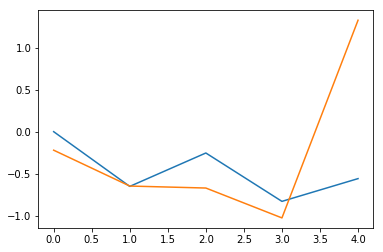

torch.Size([128, 8, 32000])
torch.Size([128, 8, 32000])
torch.Size([128, 8, 32000])
torch.Size([128, 8, 32000])
torch.Size([128, 8, 32000])
torch.Size([128, 8, 32000])


KeyboardInterrupt: 

In [98]:
i = 0
C = 0.07
l2 = 0.03
for epoch in range(100):  # loop over the dataset multiple times
    
    train_gen = ESC50(folds=train_splits,
                  randomize=True,
                  strongAugment=True,
                  random_crop=True,
                  inputLength=2,
                  mix=False,
                  **shared_params).batch_gen(128)
    
    running_loss = 0.0
    for inputs, labels in train_gen:
        # get the inputs
        inputs, labels = torch.Tensor(inputs).transpose(1,2).cuda(), torch.LongTensor(labels).cuda()

        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(inputs)

        _, labels = torch.max(labels, 1)
        
        loss = criterion(outputs, labels, net.wavelet.weight_hi, net.wavelet.weight_lo, C, l2)
        scheduler.step(loss)
        loss.backward()
        optimizer.step()
        
        
        if i%100 == 0:
            if net.wavelet.norm:
                hi,lo = net.wavelet.hi_Norm(net.wavelet.weight_hi), net.wavelet.lo_Norm(net.wavelet.weight_lo)
                print (epoch,i,net.wavelet.energy(hi), net.wavelet.energy(lo), \
                       net.wavelet.hi_Norm.B, loss.data)
            else:
                hi,lo = net.wavelet.weight_hi, net.wavelet.weight_lo
                print (epoch,i,net.wavelet.energy(hi), net.wavelet.energy(lo), \
                       hi.sum(), loss.data)
                
            idx = torch.arange(hi.size(2)-1, -1, -1).long()
            hi_f,lo_f = fft(hi[0,0,idx].cpu().data.numpy()), fft(lo[0,0,idx].cpu().data.numpy())
            n = hi_f.shape[-1]
            plt.plot(range(n//2),hi_f[:n//2])
            plt.plot(range(n//2),lo_f[:n//2])
            plt.show()
        i+=1
#         print (net.wavelet.energy(net.wavelet.weight_lo), net.wavelet.energy(net.wavelet.weight_hi), net.wavelet.lo_Norm.L.grad, loss.data)
        
        writer.add_scalar("loss", loss.item())

In [17]:
net.wavelet.hi_Norm.L, net.wavelet.hi_Norm(net.wavelet.weight_hi).pow(2).sum(), net.wavelet.weight_hi.pow(2).sum()

(Parameter containing:
 tensor([0.9811], device='cuda:0', requires_grad=True),
 tensor(3.4062, device='cuda:0', grad_fn=<SumBackward0>),
 tensor(1.3571, device='cuda:0', grad_fn=<SumBackward0>))

In [24]:
torch.save(net.state_dict(),'test_save')

In [15]:
test_load = classifier(4, 8, disp=False, norm=False)
test_load.load_state_dict(torch.load('test_save'))
test_load.cuda()

classifier(
  (wavelet): Wavelet()
  (conv1): Conv1d(5, 15, kernel_size=(3,), stride=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(15, 20, kernel_size=(3,), stride=(1,))
  (conv3): Conv1d(20, 25, kernel_size=(3,), stride=(1,))
  (lastpool): AdaptiveAvgPool1d(output_size=1)
  (fc1): Linear(in_features=25, out_features=120, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=120, out_features=10, bias=True)
)

In [25]:
total = 0
correct = 0
train_gen = ESC50(folds=train_splits,
                  randomize=True,
                  strongAugment=True,
                  random_crop=True,
                  inputLength=2,
                  mix=False,
                  **shared_params).batch_gen(256)
for inputs, labels in test_gen:
        # get the inputs
        inputs, labels = torch.Tensor(inputs).transpose(1,2).cuda(), torch.LongTensor(labels).cuda()

        # forward + backward + optimize
        outputs = net(inputs)

        _, predicted = torch.max(outputs, 1)
        _, labels = torch.max(labels, 1)
        
#         loss = criterion(outputs, labels, net.wavelet.weight_hi, net.wavelet.weight_lo, C, l2)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network: %d %%' % (100 * correct / total))

KeyboardInterrupt: 

In [26]:
print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 80 %


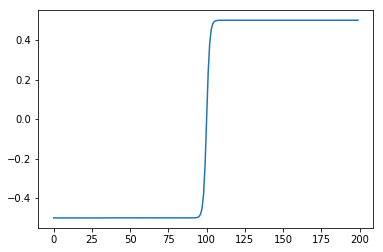

In [45]:
data = []
for i in range(-100,100):
    data.append(F.sigmoid(torch.Tensor([i]))-0.5)
plt.plot(data)

/home/ilya/anaconda3/envs/torch/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


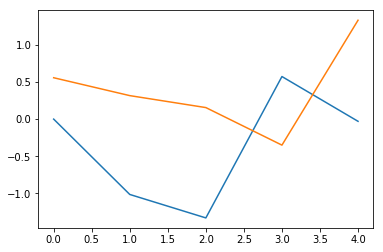

In [223]:
hi,lo = net.wavelet.weight_hi, net.wavelet.weight_lo
idx = torch.arange(hi.size(2)-1, -1, -1).long()
hi_f,lo_f = fft(hi[0,0,idx].cpu().data.numpy()), fft(lo[0,0,idx].cpu().data.numpy())
n = hi_f.shape[-1]
plt.plot(range(n//2),hi_f[:n//2])
plt.plot(range(n//2),lo_f[:n//2]);

In [80]:
train_gen = ESC50(folds=train_splits,
                  randomize=True,
                  strongAugment=True,
                  random_crop=True,
                  inputLength=2,
                  mix=False,
                  **shared_params).batch_gen(16)
inputs, labels = next(train_gen)
print (inputs.shape)

inputs, labels = torch.Tensor(inputs).transpose(1,2).cuda(), torch.LongTensor(labels).cuda()
print (inputs.shape)
stfts = torch.stft(inputs.squeeze(), n_fft=2047, hop_length=2047//2, win_length=2047, \
                   window=torch.hamming_window(2047).cuda(), center=False)
ads_stfts = stfts.pow(2).sum(-1).sqrt()
# model(inputs).shape

(16, 32000, 1)
torch.Size([16, 1, 32000])


In [79]:
stfts.shape, ads_stfts.shape

(torch.Size([16, 1024, 30, 2]), torch.Size([16, 1024, 30]))

In [106]:
class classifier_stft(nn.Module):
    def __init__(self, n_fft, stride=1,padding=1, dilation=1, groups=1):
        super(classifier_stft, self).__init__()
        self.n_fft = n_fft
        self.window = nn.Parameter(torch.hamming_window(self.n_fft), requires_grad=False)
        
        self.conv1 = nn.Conv1d(30, 15, 3)
        self.pool = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(15,20,3)
        self.conv3 = nn.Conv1d(20,25,3)
        self.lastpool = nn.AdaptiveAvgPool1d(1)
        self.fc1 = nn.Linear(25,120)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(120,10)

    def stft(self,x):        
        stfts = torch.stft(x.squeeze(), n_fft=self.n_fft, hop_length=self.n_fft//2, win_length=self.n_fft, \
                   window=self.window, center=False)
        return stfts.pow(2).sum(-1).sqrt().transpose(1,2)
        
    def forward(self,x):
        
        encoded_x = self.stft(x)
        output = self.pool(self.conv1(encoded_x))
        output = self.pool(self.conv2(output))
        output = self.conv3(output)
        output = self.lastpool(output)
        output = self.relu(self.fc1(output.squeeze()))
        output = self.fc2(output)
        
        return output

In [129]:
net_st = classifier_stft(2047)
net_st.cuda()

classifier_stft(
  (conv1): Conv1d(30, 15, kernel_size=(3,), stride=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(15, 20, kernel_size=(3,), stride=(1,))
  (conv3): Conv1d(20, 25, kernel_size=(3,), stride=(1,))
  (lastpool): AdaptiveAvgPool1d(output_size=1)
  (fc1): Linear(in_features=25, out_features=120, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=120, out_features=10, bias=True)
)

In [130]:
writer = SummaryWriter('stft0')
criterion = nn.CrossEntropyLoss()

In [133]:
optimizer = optim.SGD(net_st.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.7,patience=150, verbose=True, threshold=0.01)

In [ ]:
i = 0
C = 0.07
l2 = 0.03
for epoch in range(100):  # loop over the dataset multiple times
    
    train_gen = ESC50(folds=train_splits,
                  randomize=True,
                  strongAugment=True,
                  random_crop=True,
                  inputLength=2,
                  mix=False,
                  **shared_params).batch_gen(128)
    
    running_loss = 0.0
    for inputs, labels in train_gen:
        # get the inputs
        inputs, labels = torch.Tensor(inputs).cuda(), torch.LongTensor(labels).cuda()

        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net_st(inputs)

        _, labels = torch.max(labels, 1)
        
        loss = criterion(outputs, labels)
        scheduler.step(loss)
        
        loss.backward()
        optimizer.step()
        
        
        if i%50 == 0:
            
            _, predicted = torch.max(outputs, 1)
            
            print (epoch,i,loss.data,(predicted==labels).float().mean()) 
                
        i+=1
#         print (net.wavelet.energy(net.wavelet.weight_lo), net.wavelet.energy(net.wavelet.weight_hi), net.wavelet.lo_Norm.L.grad, loss.data)
        
        writer.add_scalar("loss", loss.item())

0 0 tensor(2.3628, device='cuda:0') tensor(0.1797, device='cuda:0')
0 50 tensor(1.3386, device='cuda:0') tensor(0.5000, device='cuda:0')
0 100 tensor(1.2583, device='cuda:0') tensor(0.5625, device='cuda:0')


In [ ]:
# net_st.conv1.weight.grad